In [1]:
# https://arxiv.org/abs/1912.10189

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from random import randrange
from tqdm import tqdm

import torch
import torch.nn as nn

Matplotlib created a temporary cache directory at /tmp/matplotlib-s53f65v6 because the default path (/home/jupyter-ikharitonov/.cache/matplotlib) is not a writable directory; it is highly recommended to set the MPLCONFIGDIR environment variable to a writable directory, in particular to speed up the import of Matplotlib and to better support multiprocessing.


## Constructing the input: angular velocity (AV), head direction (HD)

In [3]:
# Made to match the distribution in the paper

AV_TS = [0]
AV_TS_zero_inflated = [0]

def convert_to_deg_s_units(AV):
    # converts from deg/timestep to def/s
    return AV * (1000 / 25)

def AV_t(AV_t_prev, mean = 0, std = 1, sigma = 0.03, momentum = 0.8):
    AV_t_prev *= np.pi / 180 # conversion to radians
    X = np.random.normal(mean, std) * np.random.binomial(1,0.1)
    new_AV = sigma * X + momentum * AV_t_prev
    new_AV *= 180 / np.pi # conversion to degrees
    return new_AV

for i in range(120000//1):
    AV_TS.append(AV_t(AV_TS[-1]))
    AV_TS_zero_inflated.append(AV_t(AV_TS_zero_inflated[-1], std = 0.1))

AV_TS = np.array(AV_TS)
# AV_TS_zero_inflated = np.array(AV_TS_zero_inflated)
# AV_TS = np.concatenate((AV_TS, AV_TS_zero_inflated))

In [4]:
AV_TS

array([0.        , 0.        , 0.        , ..., 0.21933653, 0.17546923,
       1.65523271])

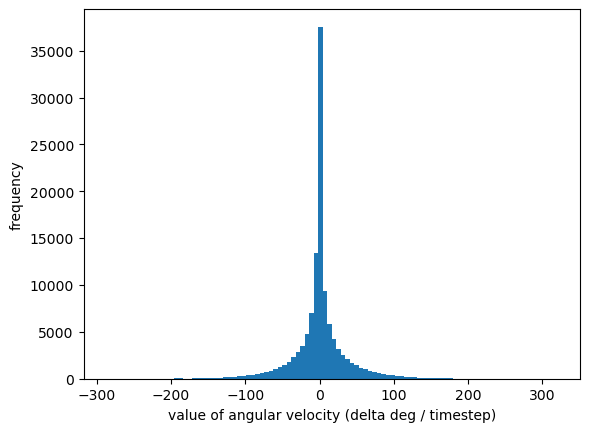

In [5]:
plt.hist(convert_to_deg_s_units(AV_TS), bins = 100)
plt.xlabel('value of angular velocity (delta deg / timestep)')
plt.ylabel('frequency')
plt.show()

Text(0, 0.5, 'angular velocity (delta deg / timestep)')

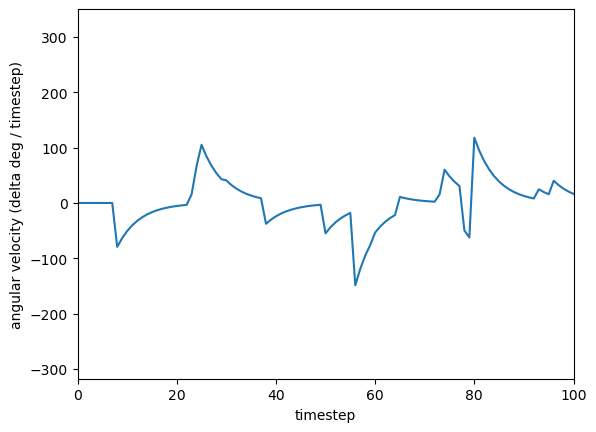

In [6]:
plt.plot(convert_to_deg_s_units(AV_TS))
plt.xlim([700,1000])
plt.xlim([0,100])
plt.xlabel('timestep')
plt.ylabel('angular velocity (delta deg / timestep)')

In [7]:
AV_t(100)

80.00000000000001

In [8]:
HD_0 = 0 # initial HD (degrees)

In [9]:
def get_next_HD(HD_old, AV_new):
    # AV_new = delta HD because we are computing HD at each timestep
    return HD_old + AV_new

def get_target_HD(HD_0, AV_TS):
    HD_TS = [HD_0]
    
    for i in range(1,len(AV_TS)):
        HD_TS.append(get_next_HD(HD_TS[-1], AV_TS[i]))
    
    return np.array(HD_TS)

def convert_to_sincos_HD(HD_TS):
    # converting degrees to radians
    m = np.pi / 180
    # converting to sin cos form
    HD_TS_converted = [[np.sin(m*x), np.cos(m*x)] for x in list(HD_TS)]
    return np.array(HD_TS_converted)

def convert_from_sincos_HD(HD_TS):
    output = np.arctan2(HD_TS[:,0], HD_TS[:,1]) * (180 / np.pi)
    return output

In [10]:
target_HD_signal = get_target_HD(HD_0, AV_TS)
target_HD_signal.shape

(120001,)

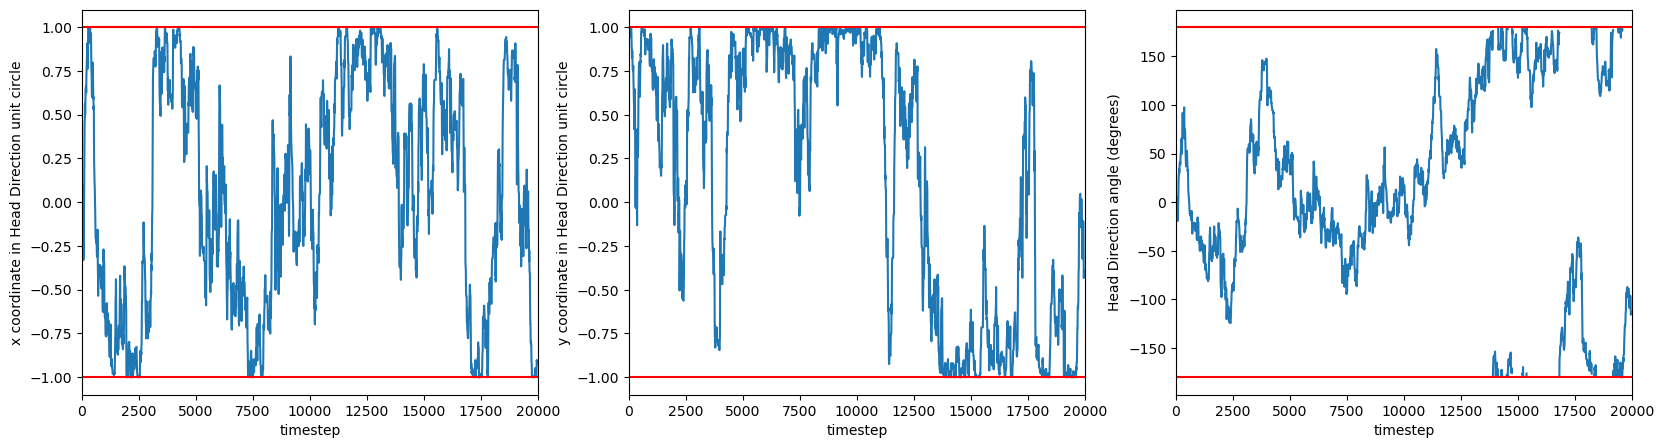

In [11]:
fig, ax = plt.subplots(nrows=1, ncols=3, figsize=(20,5))

sincos_HD_signal = convert_to_sincos_HD(target_HD_signal)
ax[0].plot(np.arange(target_HD_signal.shape[0]), sincos_HD_signal[:,0])
ax[0].set_xlabel("timestep")
ax[0].set_ylabel("x coordinate in Head Direction unit circle")
ax[0].set_xlim([0,20000])
ax[0].axhline(1, c='r')
ax[0].axhline(-1, c='r')

ax[1].plot(np.arange(target_HD_signal.shape[0]), sincos_HD_signal[:,1])
ax[1].set_xlabel("timestep")
ax[1].set_ylabel("y coordinate in Head Direction unit circle")
ax[1].set_xlim([0,20000])
ax[1].axhline(1, c='r')
ax[1].axhline(-1, c='r')

reconverted_signal = convert_from_sincos_HD(convert_to_sincos_HD(target_HD_signal))

# For visualisation purposes of discontinuous segments, from https://stackoverflow.com/questions/53107657/how-to-eliminate-connecting-line-when-plotting-unwrapped-function
diffs = np.append(np.diff(reconverted_signal), 0)
discont_indices = np.abs(diffs) > 180
reconverted_signal[discont_indices] = np.nan

ax[2].plot(np.arange(len(reconverted_signal)), reconverted_signal)
ax[2].set_xlabel("timestep")
ax[2].set_ylabel("Head Direction angle (degrees)")
ax[2].set_xlim([0,20000])
ax[2].axhline(180, c='r')
ax[2].axhline(-180, c='r')
plt.show()

In [12]:
# input = [np.sin(HD_0), np.cos(HD_0), AV_t]

## Defining the network

In [13]:
input_sequence_length = 10
hidden_units = 1
input_dimension = 1
N_batch = 1

In [14]:
rnn_input = torch.randn(N_batch, input_sequence_length, input_dimension)
print(rnn_input.shape)
rnn_input

torch.Size([1, 10, 1])


tensor([[[-0.5851],
         [-0.8536],
         [-0.0795],
         [ 1.4525],
         [ 0.1572],
         [ 0.8736],
         [ 1.0628],
         [-0.7370],
         [ 0.2212],
         [ 0.1385]]])

In [15]:
W_ih = nn.Parameter(torch.ones(hidden_units, input_dimension))
W_hh = nn.Parameter(torch.ones(hidden_units, hidden_units))

b_ih = nn.Parameter(torch.ones(hidden_units))
b_hh = nn.Parameter(torch.ones(hidden_units))

relu = nn.ReLU()

In [16]:
def get_hidden_state(h_t_prev, rnn_input_t):
    return relu(W_ih.T * rnn_input_t + b_ih + h_t_prev * W_hh.T + b_hh).detach()

In [17]:
h_array = [0]
for i in range(input_sequence_length):
    h_array.append(get_hidden_state(h_array[-1], rnn_input[:,i]))
h_array.pop(0)
output1 = np.array([x.detach()[0] for x in h_array])
output1

array([[ 1.4149435],
       [ 2.561375 ],
       [ 4.4818606],
       [ 7.9343414],
       [10.091543 ],
       [12.965172 ],
       [16.027927 ],
       [17.290945 ],
       [19.512135 ],
       [21.650682 ]], dtype=float32)

In [18]:
HD_0 = 0
AV_0 = 0
for i in range(10):
    print(HD_0)
    AV_0 = AV_t(AV_0)
    HD_0 = get_next_HD(HD_0, AV_0)

0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0


In [19]:
def dx_dt(x_t, I_t, epsilon_t):
    (1 / tau) * -x_t + np.sum(W_rec * nonlinearity(x_t)) + np.sum(W_in * I_t) + b + epsilon_t

In [20]:
# def simulation(x_0, I_t, epsilon_t):
#     T = 500
#     delta_t = 25 / 1000
#     x_t = [x_0]
    
#     for i in range(T):
#         x_t.append(x_t[-1] + delta_t * dx_dt(x_t[-1], I_t, epsilon_t))
#     return x_t

\begin{align}
    \tau \frac{d\mathbf{x}}{dt} = -\mathbf{x}(t) + W_{rec}f(\mathbf{x}(t)) + W_{input} \mathbf{I_t} + \mathbf{b} + \xi_t
\end{align}

\begin{align}
    f(a) = max[0, tanh(a)]
\end{align}

\begin{align}
    Euler: \mathbf{x}(t+\Delta t) = \mathbf{x}(t) + \Delta \mathbf{x}
\end{align}

\begin{align}
    \mathbf{x}(t+\Delta t) = \text{New hidden state of RNN}
\end{align}

\begin{align}
    \text{New hidden state of RNN} &= \mathbf{x}(t) + \frac{\Delta t}{\tau}[-\mathbf{x}(t) + W_{rec}f(\mathbf{x}(t)) + W_{input} \mathbf{I_t} + \mathbf{b} + \xi_t]\\
     &= (1 - \frac{\Delta t}{\tau}) \mathbf{x}(t) + \frac{\Delta t}{\tau}[W_{rec}f(\mathbf{x}(t)) + W_{input} \mathbf{I_t} + \mathbf{b} + \xi_t]
\end{align}

In [21]:
torch.cuda.is_available()

True

In [22]:
compute_device = torch.device('cuda')

In [23]:
class AngularVelocityInputConstructor():
    def __init__(self):
        self.initialised = False
        
    def AV_t(self, AV_t_prev, mean = 0, std = 1, sigma = 0.03, momentum = 0.8):
        AV_t_prev *= np.pi / 180 # conversion to radians
        X = np.random.normal(mean, std) * np.random.binomial(1,0.1)
        new_AV = sigma * X + momentum * AV_t_prev
        new_AV *= 180 / np.pi # conversion to degrees
        return new_AV
    
    def get_next_HD(self, HD_old, AV_new):
        # AV_new = delta HD because we are computing HD at each timestep
        return HD_old + AV_new
    
    def get_initial_HD_as_sincos(self):
        HD = self.HD_array[0]
        # converting degrees to radians
        HD *= np.pi / 180
        # converting to sin cos form
        HD_converted = [np.sin(HD), np.cos(HD)]
        return HD_converted
    
    def init_variables(self):
        self.HD_0 = randrange(-180, 180) # initial head direction
        self.HD_array = [self.HD_0]
        self.AV_0 = np.random.normal(0,100) # initial angular velocity
        # self.AV_0 = 0
        self.AV_array = [self.AV_0]
    
    def next_AV(self):
        if not self.initialised:
            self.init_variables()
            self.initialised = True
        else:
            # Get next values for AV and HD and store them into arrays
            self.AV_0 = self.AV_t(self.AV_0)
            self.AV_array.append(self.AV_0)
            self.HD_0 = self.get_next_HD(self.HD_0, self.AV_0)
            self.HD_array.append(self.HD_0)
        return self.AV_0
    
    def get_input_tensor(self):
        # Construct the input in the format needed by RNN
        new_AV = self.next_AV()
        initial_HD = self.get_initial_HD_as_sincos()
        return torch.tensor(initial_HD + [new_AV], dtype=torch.float32)
    
    def get_HD_target(self):
        return [[np.sin(HD), np.cos(HD)] for HD in self.HD_array] # converting HD angles in degrees to sin cos components



class ContinuousTimeRNN(nn.Module):
    def __init__(self, input_dimension = 3, hidden_units = 100, output_dimension = 2, T = 500):
        super(ContinuousTimeRNN, self).__init__()
        
        self.parameter_list = nn.ParameterList()
        
        self.tau = 0.25 # time constant = 250 ms
        self.dt = self.tau / 10 # timestep = tau / 10
        self.T = T # timesteps of Euler's simulation
        
        self.hidden_state = torch.zeros(hidden_units).to(compute_device)
        
        self.W_rec = nn.Parameter(torch.randn(hidden_units, hidden_units)).to(compute_device)
        self.W_in = nn.Parameter(torch.randn(hidden_units, input_dimension)).to(compute_device)
        self.W_out = nn.Parameter(torch.randn(output_dimension, hidden_units)).to(compute_device)
        
        self.bias = nn.Parameter(torch.randn(hidden_units)).to(compute_device)
        
        # To add the above nn.Parameters to the list of backpropagated parameters
        self.parameter_list.append(self.W_rec)
        self.parameter_list.append(self.W_in)
        self.parameter_list.append(self.W_out)
        self.parameter_list.append(self.bias)
        
        self.relu = nn.ReLU()
    
    def get_noise(self):
        return torch.rand(self.hidden_state.shape[0]).to(compute_device)
    
    def nonlin(self, x):
        return relu(torch.tanh(x))
    
    def simulate_equation(self, input):
        # One step of Euler's method, see equation above
        h = self.dt / self.tau
        new_hidden_state = torch.matmul(self.W_rec, self.nonlin(self.hidden_state)) + torch.matmul(self.W_in, input) + self.bias + self.get_noise()
        new_hidden_state = (1 - h) * self.hidden_state + h * new_hidden_state
        return new_hidden_state
        
    def forward(self):
        output_state = torch.zeros(self.T, 2)
        InputObject = AngularVelocityInputConstructor()
        
        # Running Euler simulation and collecting output from readout nodes
        for i in range(self.T):
            input = InputObject.get_input_tensor().to(compute_device)
            new_hidden_state = self.simulate_equation(input)
            output_state[i] = torch.matmul(self.W_out, self.nonlin(new_hidden_state))
        
        return output_state, torch.tensor(InputObject.get_HD_target(), dtype=torch.float32)
        # return output_state, InputObject.get_HD_target()

In [24]:
# Checking matmul output dimensions
tensor1 = torch.randn(100, 3)
tensor2 = torch.randn(3)
print(tensor1.shape, tensor2.shape, torch.matmul(tensor1, tensor2).shape)

torch.Size([100, 3]) torch.Size([3]) torch.Size([100])


## Training loop

In [31]:
model = ContinuousTimeRNN(input_dimension=3, hidden_units=100).to(compute_device)

criterion = nn.MSELoss()

learning_rate = 0.00001
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate, weight_decay=1e-5) # weight_decay adds L2 regularisation (metabolic cost) to the cost function

In [32]:
losses = []
for epoch in range(500):
    optimizer.zero_grad()
    output_HD_sequence, target_HD_sequence = model()
    # print(output_HD_sequence.shape, target_HD_sequence.shape)
    loss = criterion(output_HD_sequence, target_HD_sequence)
    loss.backward()
    optimizer.step()
    losses.append(loss.item())
    print(f'Epoch {epoch+1}, Loss: {loss.item():.4f}')

Epoch 1, Loss: 1.2402
Epoch 2, Loss: 1.7277
Epoch 3, Loss: 1.0900
Epoch 4, Loss: 5.1810
Epoch 5, Loss: 1.5372
Epoch 6, Loss: 4.3204
Epoch 7, Loss: 1.4937
Epoch 8, Loss: 1.3196
Epoch 9, Loss: 2.7296
Epoch 10, Loss: 4.7056
Epoch 11, Loss: 0.9378
Epoch 12, Loss: 2.0532
Epoch 13, Loss: 2.3635
Epoch 14, Loss: 1.3112
Epoch 15, Loss: 2.0023
Epoch 16, Loss: 2.8173
Epoch 17, Loss: 0.9627
Epoch 18, Loss: 1.4739
Epoch 19, Loss: 1.7611
Epoch 20, Loss: 1.0270
Epoch 21, Loss: 1.1109
Epoch 22, Loss: 4.3690
Epoch 23, Loss: 3.9749
Epoch 24, Loss: 1.6511
Epoch 25, Loss: 4.6012
Epoch 26, Loss: 1.2938
Epoch 27, Loss: 1.1497
Epoch 28, Loss: 1.4453
Epoch 29, Loss: 1.0741
Epoch 30, Loss: 1.4564
Epoch 31, Loss: 1.7155
Epoch 32, Loss: 2.7916
Epoch 33, Loss: 1.8908
Epoch 34, Loss: 1.3909
Epoch 35, Loss: 1.6206
Epoch 36, Loss: 1.7099
Epoch 37, Loss: 5.4790
Epoch 38, Loss: 4.9855
Epoch 39, Loss: 1.4196
Epoch 40, Loss: 3.0535
Epoch 41, Loss: 2.2427
Epoch 42, Loss: 1.1584
Epoch 43, Loss: 5.0551
Epoch 44, Loss: 1.21

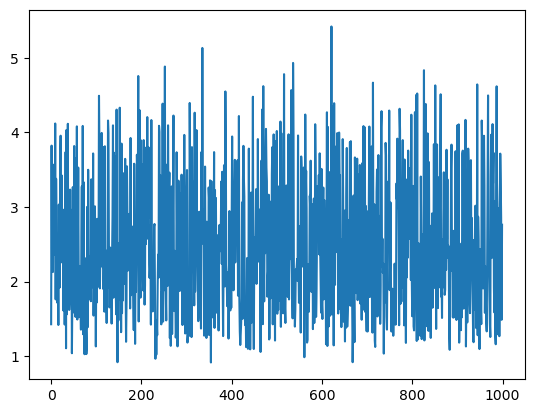

In [27]:
plt.plot(losses)

(0.0, 40.0)

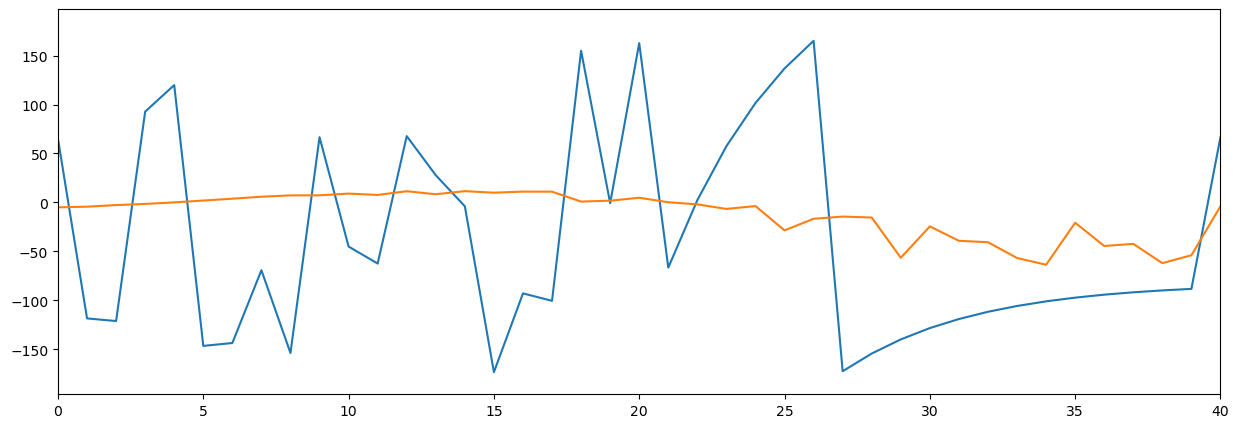

In [28]:
plt.figure(figsize=(15,5))
plt.plot(convert_from_sincos_HD(target_HD_sequence))
plt.plot(convert_from_sincos_HD(output_HD_sequence.detach().numpy()))
plt.xlim([0,40])